In [1]:
!pip install xgboost

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 173.5 MB 163 kB/s eta 0:00:016   |                                | 153 kB 16.9 MB/s eta 0:00:11
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
total = pd.read_csv('한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
total.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


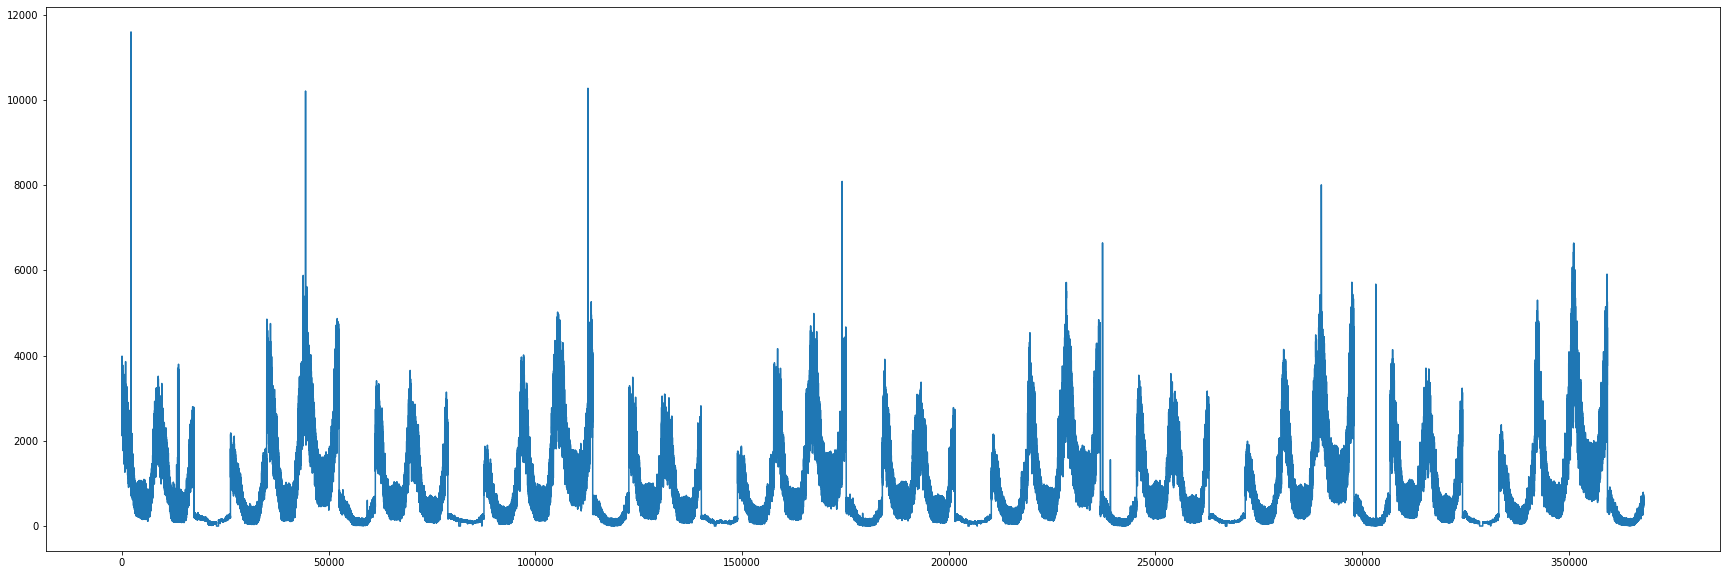

In [4]:
plt.figure(figsize=(30,10))
plt.plot(total['공급량'])   
plt.show() 

In [5]:
total['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [6]:
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

In [9]:
total['연월일'] = pd.to_datetime(total['연월일'])

total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

In [10]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

In [11]:
train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]

In [12]:
features = ['구분', 'month', 'day', 'weekday', '시간']
train_x = train[features]
train_y = train['공급량']

val_x = val[features]
val_y = val['공급량']

# Train

In [13]:
from xgboost import XGBRegressor

dtrain = xgb.DMatrix(data=train_x, label = train_y)
dval = xgb.DMatrix(data=val_x, label = val_y)
wlist = [(dtrain, 'train'), (dval,'eval')]

params = {
    'learning_rate': 0.05,
    'objective': 'reg:squarederror',
    'metric':'mae', 
    'seed':42
}
 

model = xgb.train( params, dtrain, 500, evals=wlist, verbose_eval=20, early_stopping_rounds=100)

[13:12:43] WARNING: ../src/learner.cc:576: 
Parameters: { "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:1242.69727	eval-rmse:1369.83215
[20]	train-rmse:528.03296	eval-rmse:651.96582
[40]	train-rmse:311.36914	eval-rmse:420.69913
[60]	train-rmse:243.83812	eval-rmse:339.29675
[80]	train-rmse:216.09639	eval-rmse:305.47705
[100]	train-rmse:203.10265	eval-rmse:288.67331
[120]	train-rmse:196.05751	eval-rmse:279.66217
[140]	train-rmse:191.00426	eval-rmse:273.58994
[160]	train-rmse:187.00163	eval-rmse:269.42844
[180]	train-rmse:184.03245	eval-rmse:267.28821
[200]	train-rmse:181.11749	eval-rmse:265.83676
[220]	train-rmse:178.85315	eval-rmse:264.56049
[240]	train-rmse:176.34041	eval-rmse:263.64191
[260]	train-rmse:174.47710	eval-rmse

# Inference

In [15]:
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [16]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [17]:
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [18]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [19]:
test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday

In [20]:
test['구분'] = test['구분'].map(d_map)

In [21]:
test_x = test[features]
test_x = xgb.DMatrix(test_x)
preds = model.predict(test_x)

In [22]:
submission['공급량'] = preds
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,2385.728271
1,2019-01-01 02 A,2166.335938
2,2019-01-01 03 A,2067.060547
3,2019-01-01 04 A,2018.731323
4,2019-01-01 05 A,2191.799072


In [23]:
submission.to_csv("XGBoost_Baseline.csv",index=False)